In [11]:
import os
import cv2
import time
import shutil
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
sns.set_style('darkgrid')
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import cv2

from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Model, load_model, Sequential
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
print ('modules loaded')

modules loaded


In [12]:
def define_paths(dir):
    folds = os.listdir(dir)
    files = []
    classes = []
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        # Check if it's a directory before trying to list its contents
        if os.path.isdir(foldpath):
            filelist = os.listdir(foldpath)
            for file in filelist:
                fpath = os.path.join(foldpath, file)
                files.append(fpath)
                classes.append(fold)
    return files, classes

def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

def create_df(tr_dir, val_dir, ts_dir):
    # train dataframe
    files, classes = define_paths(tr_dir)
    train_df = define_df(files, classes)

    # validation dataframe
    files, classes = define_paths(val_dir)
    valid_df = define_df(files, classes)
    # test dataframe
    files, classes = define_paths(ts_dir)
    test_df = define_df(files, classes)
    return train_df, valid_df, test_df

In [13]:
def create_gens(train_df, valid_df, test_df, batch_size):
    img_size = (224, 224)
    channels = 3
    img_shape = (img_size[0], img_size[1], channels)
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))
    test_steps = ts_length // test_batch_size

   
    def scalar(img):
        return img

   
  
    tr_gen = ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True, vertical_flip=True)
    ts_gen = ImageDataGenerator(preprocessing_function=scalar)

    # Calculate class weights
    y_train = train_df['labels'].values
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    class_weights = dict(enumerate(class_weights))  # Convert to dictionary for ImageDataGenerator

    train_gen = tr_gen.flow_from_dataframe(
        train_df,
        x_col='filepaths',
        y_col='labels',
        target_size=img_size,
        class_mode='categorical',
        color_mode='rgb',
        shuffle=True,
        batch_size=batch_size,
        class_weight=class_weights
    )

    valid_gen = ts_gen.flow_from_dataframe(
        valid_df,
        x_col='filepaths',
        y_col='labels',
        target_size=img_size,
        class_mode='categorical',
        color_mode='rgb',
        shuffle=True,
        batch_size=batch_size
    )

    test_gen = ts_gen.flow_from_dataframe(
        test_df,
        x_col='filepaths',
        y_col='labels',
        target_size=img_size,
        class_mode='categorical',
        color_mode='rgb',
        shuffle=False,
        batch_size=test_batch_size
    )

    return train_gen, valid_gen, test_gen


In [14]:
def show_images(gen):
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes)
    images, labels = next(gen)        # get a batch size samples from the generator
    plt.figure(figsize= (20, 20))
    length = len(labels)              # length of batch size
    sample = min(length, 25)          # check if sample less than 25 images
    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] /255.0   
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

In [15]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, base_model, patience, stop_patience, threshold, factor, dwell, batches, initial_epoch, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        self.base_model = base_model
        self.patience = patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience = stop_patience # specifies how many times to adjust lr without improvement to stop training
        self.threshold = threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor = factor # factor by which to reduce the learning rate
        self.dwell = dwell
        self.batches = batches # number of training batch to runn per epoch
        self.initial_epoch = initial_epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch # save this value to restore if restarting training
        # callback variables
        self.count = 0 # how many times lr has been reduced without improvement
        self.stop_count = 0
        self.best_epoch = 1   # epoch with the lowest loss
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initial learning rate and save it
        self.highest_tracc = 0.0 # set highest training accuracy to 0 initially
        self.lowest_vloss = np.inf # set lowest validation loss to infinity initially
        self.best_weights = self.model.get_weights() # set best weights to model's initial weights
        self.initial_weights = self.model.get_weights()   # save initial weights if they have to get restored

    # Define a function that will run when train begins
    def on_train_begin(self, logs= None):
        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()

    def on_train_end(self, logs= None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)
        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights

    def on_train_batch_end(self, batch, logs= None):
        acc = logs.get('accuracy') * 100 # get batch accuracy
        loss = logs.get('loss')
        msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end= '') # prints over on the same line to show running batch count

    def on_epoch_begin(self, epoch, logs= None):
        self.ep_start = time.time()

    # Define method runs on the end of each epoch
    def on_epoch_end(self, epoch, logs= None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr = lr
        acc = logs.get('accuracy')  # get training accuracy
        v_acc = logs.get('val_accuracy')  # get validation accuracy
        loss = logs.get('loss')  # get training loss for this epoch
        v_loss = logs.get('val_loss')  # get the validation loss for this epoch

        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc ) * 100 / self.highest_tracc # define improvement of model progres

            if acc > self.highest_tracc: # training accuracy improved in the epoch
                self.highest_tracc = acc # set new highest training accuracy
                self.best_weights = self.model.get_weights() # training accuracy improved so save the weights
                self.count = 0 # set count to 0 since training accuracy improved
                self.stop_count = 0 # set stop counter to 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1  # set the value of best epoch for this epoch

            else:
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count >= self.patience - 1: # lr should be adjusted
                    lr = lr * self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    self.count = 0 # reset the count to 0
                    self.stop_count = self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count = 0 # reset counter
                    if self.dwell:
                        self.model.set_weights(self.best_weights) # return to better point in N space
                    else:
                        if v_loss < self.lowest_vloss:
                            self.lowest_vloss = v_loss
                else:
                    self.count = self.count + 1 # increment patience counter

        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (self.lowest_vloss - v_loss ) * 100 / self.lowest_vloss
            if v_loss < self.lowest_vloss: # check if the validation loss improved
                self.lowest_vloss = v_loss # replace lowest validation loss with new validation loss
                self.best_weights = self.model.get_weights() # validation loss improved so save the weights
                self.count = 0 # reset count since validation loss improved
                self.stop_count = 0
                self.best_epoch = epoch + 1 # set the value of the best epoch to this epoch
            else: # validation loss did not improve
                if self.count >= self.patience - 1: # need to adjust lr
                    lr = lr * self.factor # adjust the learning rate
                    self.stop_count = self.stop_count + 1 # increment stop counter because lr was adjusted
                    self.count = 0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    if self.dwell:
                        self.model.set_weights(self.best_weights) # return to better point in N space
                else:
                    self.count = self.count + 1 # increment the patience counter
                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg = f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True # stop training

        else:
            if self.ask_epoch != None:
                if epoch + 1 >= self.ask_epoch:
                    msg = 'enter H to halt training or an integer for number of epochs to run then ask again'
                    print(msg)
                    ans = input('')
                    if ans == 'H' or ans == 'h':
                        msg = f'training has been halted at epoch {epoch + 1} due to user input'
                        print(msg)
                        self.model.stop_training = True # stop training
                    else:
                        try:
                            ans = int(ans)
                            self.ask_epoch += ans
                            msg = f' training will continue until epoch ' + str(self.ask_epoch)
                            print(msg)
                            msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
                            print(msg)
                        except:
                            print('Invalid')

In [16]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)     # get number of epoch with the lowest validation loss
    val_lowest = val_loss[index_loss]    # get the loss value of epoch with the lowest validation loss
    index_acc = np.argmax(val_acc)       # get number of epoch with the highest validation accuracy
    acc_highest = val_acc[index_acc]     # get the loss value of epoch with the highest validation accuracy

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]	       # create x-axis by epochs count
    loss_label = f'best epoch= {str(index_loss + 1)}'  # label of lowest val_loss
    acc_label = f'best epoch= {str(index_acc + 1)}'    # label of highest val_accuracy
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout
    plt.show()

In [17]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
        print('Normalized Confusion Matrix')
    else:
        print('Confusion Matrix, Without Normalization')
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

Found 613 validated image filenames belonging to 4 classes.
Found 72 validated image filenames belonging to 4 classes.
Found 315 validated image filenames belonging to 4 classes.


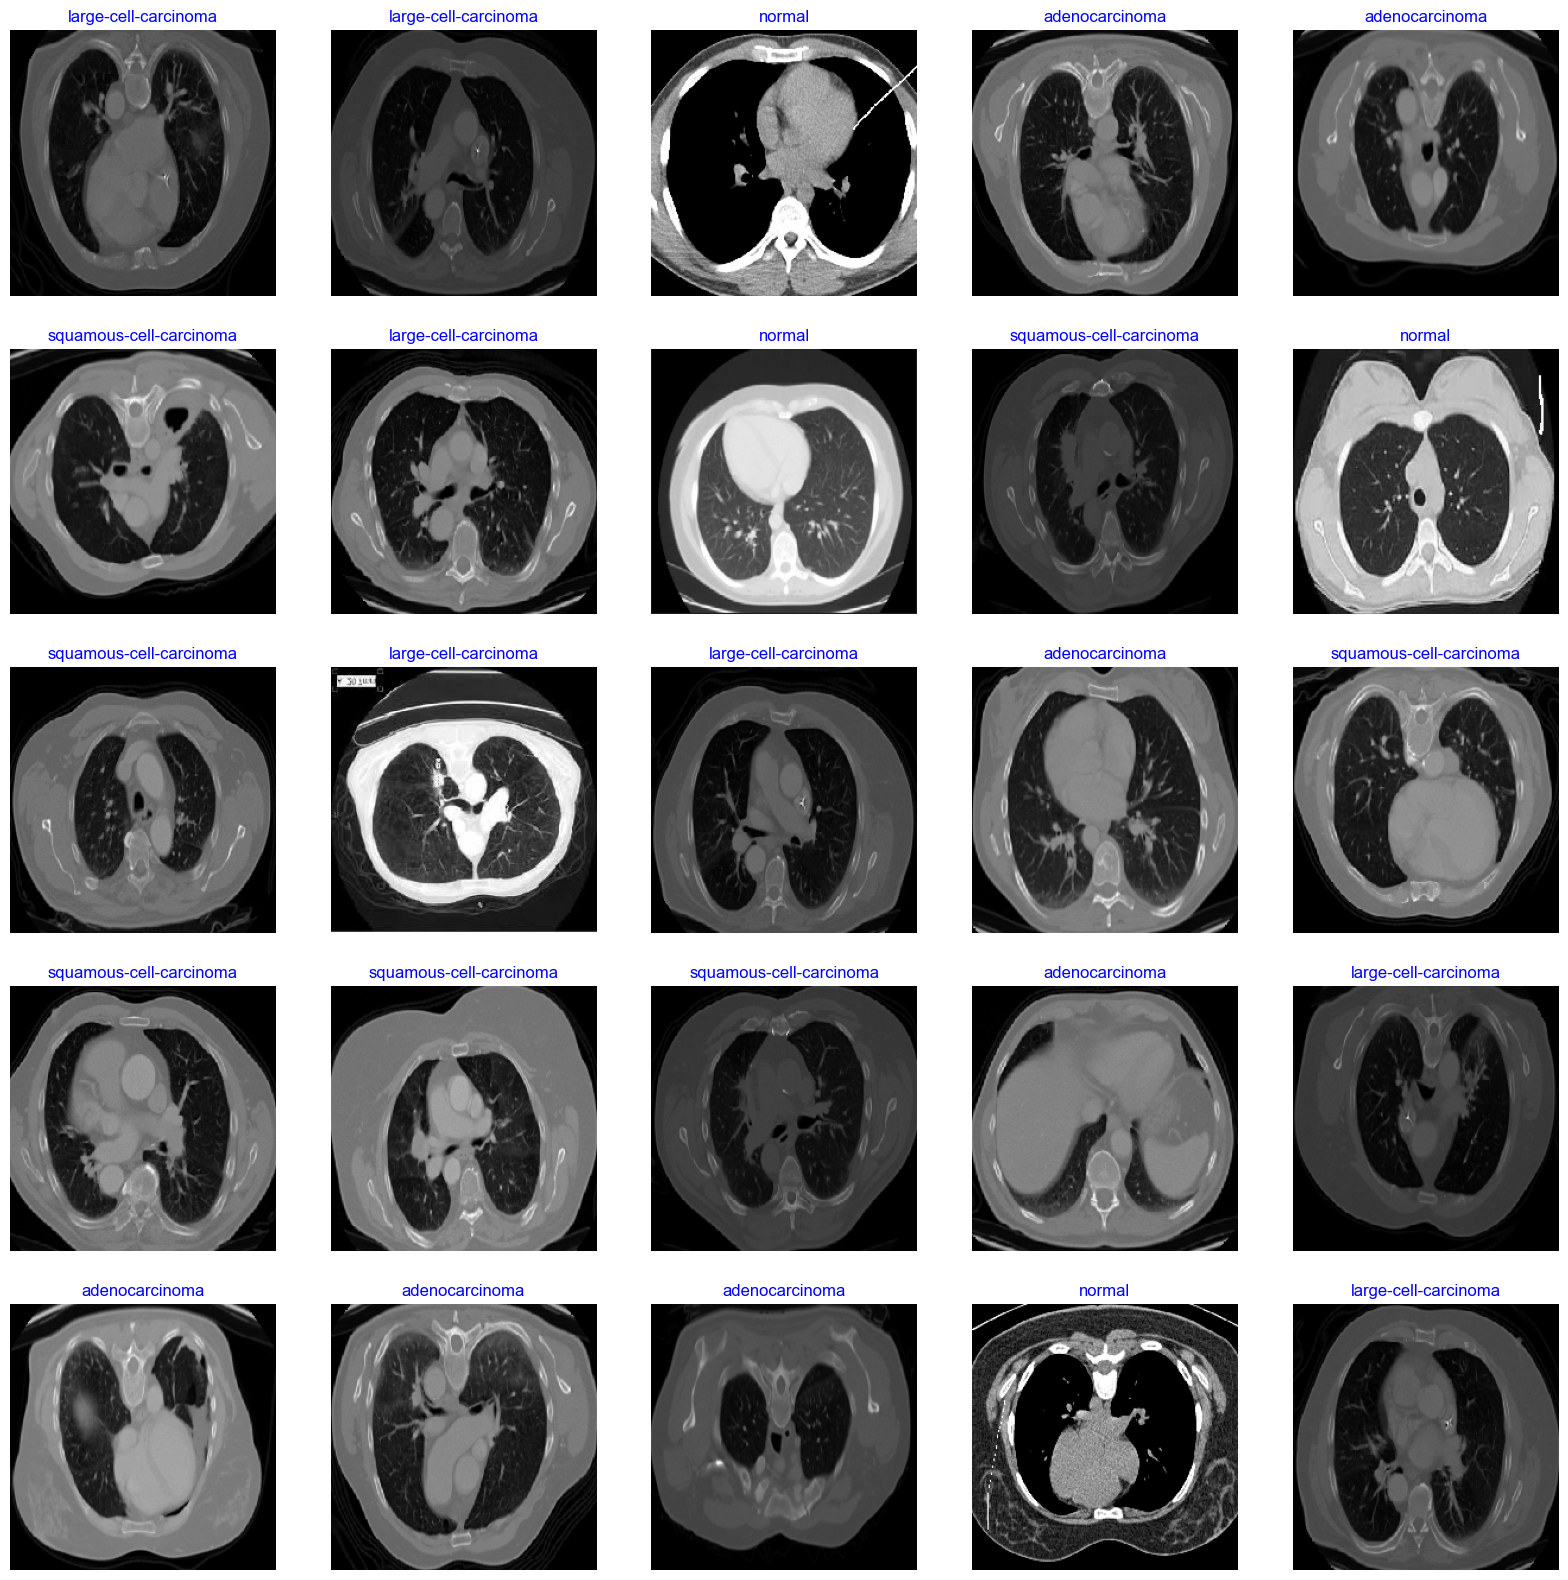

In [22]:

# Get Dataframes
train_dir ="/Users/onyekachukwuojumah/Desktop/Lung-Cancer-Detection/Data_n_experiments/train"
test_dir = "/Users/onyekachukwuojumah/Desktop/Lung-Cancer-Detection/Data_n_experiments/test"
valid_dir = "/Users/onyekachukwuojumah/Desktop/Lung-Cancer-Detection/Data_n_experiments/valid"
train_df, valid_df, test_df = create_df(train_dir, valid_dir, test_dir)

# Get Generators
batch_size = 40
train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

show_images(train_gen)

In [23]:
def create_eff_model():
    img_size = (224, 224)
    channels = 3
    img_shape = (img_size[0], img_size[1], channels)
    class_count = len(list(train_gen.class_indices.keys()))  

    # create pre-trained model
    base_model = tf.keras.applications.EfficientNetB3(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')

    model = Sequential([
     
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
            
    ])

    model.summary()  # Print the model summary
    return model, base_model

eff_model, eff_base_model = create_eff_model()
eff_model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])





Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 batch_normalization (BatchN  (None, 1536)             6144      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 11,184,179
Trainable params: 11,093,804
Non-trainable params: 90,375
_______________________________________

In [ ]:
def train_eff_model(eff_model, eff_base_model, train_gen, valid_gen):
    batch_size = 8
    epochs = 20
    patience = 1        # number of epochs to wait to adjust lr if monitored value does not improve
    stop_patience = 3   # number of epochs to wait before stopping training if monitored value does not improve
    threshold = 0.95     # if train accuracy is < threshold adjust monitor accuracy, else monitor validation loss
    factor = 0.3        # factor to reduce lr by
    dwell = True        # experimental, if True and monitored metric does not improve on the current epoch, set model weights back to weights of the previous epoch
    freeze = False      # if true, freeze weights of the base model
    ask_epoch = 15     # number of epochs to run before asking if you want to halt training
    batches = int(np.ceil(len(train_gen.labels) / batch_size))

    callbacks = [MyCallback(model=eff_model, base_model=eff_base_model, patience=patience,
                            stop_patience=stop_patience, threshold=threshold, factor=factor,
                            dwell=dwell, batches=batches, initial_epoch=0, epochs=epochs, ask_epoch=ask_epoch)]

    history = eff_model.fit(x=train_gen, epochs=epochs, verbose=1, callbacks=callbacks,
                        validation_data=valid_gen, validation_steps=None, shuffle=False,
                        initial_epoch=0)

    return history

eff_history = train_eff_model(eff_model, eff_base_model, train_gen, valid_gen)

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
Epoch 1/20


2024-01-06 21:38:59.890935: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


16/16 [==============================] - ETA: 0s - loss: 3.5802 - accuracy: 0.9886  66379                     processing batch 1 of 77   -   accuracy=  98.750   -   loss:  3.64086                    processing batch 2 of 77   -   accuracy=  98.333   -   loss:  3.63808                    processing batch 3 of 77   -   accuracy=  98.750   -   loss:  3.63328                    processing batch 4 of 77   -   accuracy=  98.500   -   loss:  3.65405                    processing batch 5 of 77   -   accuracy=  98.333   -   loss:  3.64679                    processing batch 6 of 77   -   accuracy=  98.571   -   loss:  3.63301                    processing batch 7 of 77   -   accuracy=  98.438   -   loss:  3.63237                    processing batch 8 of 77   -   accuracy=  98.611   -   loss:  3.62966                    processing batch 9 of 77   -   accuracy=  98.750   -   loss:  3.61744                    processing batch 10 of 77   -   accuracy=  98.636   -   loss:  3.61080                   

2024-01-06 21:42:19.312268: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


 1 /20     3.580   98.858   3.93030  80.556   0.00100  0.00100  val_loss     0.00    203.18 
16/16 [==============================] - 203s 13s/step - loss: 3.5802 - accuracy: 0.9886 - val_loss: 3.9303 - val_accuracy: 0.8056
Epoch 2/20
16/16 [==============================] - 211s 13s/step - loss: 3.4100 - accuracy: 0.9902 - val_loss: 3.7371 - val_accuracy: 0.8056
Epoch 3/20
16/16 [==============================] - 242s 15s/step - loss: 3.2468 - accuracy: 0.9837 - val_loss: 3.5303 - val_accuracy: 0.8194
Epoch 4/20
16/16 [==============================] - 245s 15s/step - loss: 3.0997 - accuracy: 0.9935 - val_loss: 3.3944 - val_accuracy: 0.8056
Epoch 5/20
16/16 [==============================] - 246s 15s/step - loss: 2.9461 - accuracy: 0.9935 - val_loss: 3.2113 - val_accuracy: 0.8611
Epoch 6/20
16/16 [==============================] - 274s 17s/step - loss: 2.8166 - accuracy: 0.9869 - val_loss: 3.0770 - val_accuracy: 0.8472
Epoch 7/20
16/16 [==============================] - 204s 13s/step 

In [19]:
def display_eff_result(eff_model, test_gen, eff_history):
    plot_training(eff_history)

    ts_length = len(test_gen)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))
    test_steps = ts_length // test_batch_size
    train_score = eff_model.evaluate(train_gen, steps=test_steps, verbose=1)
    valid_score = eff_model.evaluate(valid_gen, steps=test_steps, verbose=1)
    test_score = eff_model.evaluate(test_gen, steps=test_steps, verbose=1)

    print("Train Loss: ", train_score[0])
    print("Train Accuracy: ", train_score[1])
    print('-' * 20)
    print("Validation Loss: ", valid_score[0])
    print("Validation Accuracy: ", valid_score[1])
    print('-' * 20)
    print("Test Loss: ", test_score[0])
    print("Test Accuracy: ", test_score[1])

    preds = eff_model.predict_generator(test_gen)
    y_pred = np.argmax(preds, axis=1)
    print(y_pred)

    target_names = ['adenocarcinoma', 'large-cell-carcinoma', 'normal', 'squamous-cell-carcinoma']
    # Confusion matrix
    cm = confusion_matrix(test_gen.classes, y_pred)
    plot_confusion_matrix(cm=cm, classes=target_names, title='Confusion Matrix')
    # Classification report
    print(classification_report(test_gen.classes, y_pred, target_names=target_names))




In [20]:
display_eff_result(eff_model, test_gen, eff_history)


NameError: name 'eff_model' is not defined